# Experimento de Indexação Gist no PostgreSQL

Este notebook implementa um experimento para avaliar o desempenho de consultas SQL com volumes crescentes de dados, comparando o comportamento com e sem índices GiST.

Utilizaremos uma base de dados fictícia de uma biblioteca, com tabelas de usuários, livros e empréstimos.

In [26]:
# Imports necessários
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.db_connection import DatabaseConnection, execute_query
from utils.data_generator import BibliotecaDataGenerator

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

## Configuração do Experimento

Primeiro, vamos configurar a conexão com o banco de dados e limpar quaisquer dados existentes para garantir um ambiente consistente para o experimento.

In [27]:
# Inicializa a conexão com o banco de dados
DatabaseConnection.init_connection_pool()

# Cria uma instância do gerador de dados
gerador = BibliotecaDataGenerator(seed=42)

# Limpa o banco de dados para começar do zero
gerador.limpar_banco()
print("Banco de dados limpo e pronto para o experimento.")

Limpando o banco de dados...
Banco de dados limpo com sucesso.
Banco de dados limpo e pronto para o experimento.


## Definição da Consulta SQL para o Experimento

Os Índices GiST beneficiam campos espaciais, como o polígono de dimensões e tipos complexos, como JSON (metadados) e textos grandes.

In [ ]:
# Definição da consulta SQL
query = """
SELECT l.*
FROM livros l
WHERE 
daterange('2001-01-01', CURRENT_DATE, '[]') @> l.publicado_em and
to_tsvector('portuguese', l.titulo) @@ to_tsquery('portuguese', 'liberdade & evoluir');
"""


# Função para executar a consulta e medir o tempo
def executar_consulta_com_tempo(query):
    inicio = time.time()
    resultado = execute_query(query)
    fim = time.time()
    tempo_execucao = fim - inicio
    return resultado, tempo_execucao


# Função para criar índices gist
def criar_indices_gist():
    indices_sql = [
         # Índice para busca de texto
        "CREATE INDEX idx_livros_fulltext_gist ON livros USING gist(to_tsvector('portuguese', titulo));",
        # Índice para range queries em datas (suporta operador @>)
        "CREATE INDEX idx_livros_data_publicacao_gist ON livros USING gist(publicado_em);",
    ]

    # Adicione a extensão pg_trgm que é necessária para busca de similaridade de texto
    # execute_query("CREATE EXTENSION IF NOT EXISTS pg_trgm;")

    print("Criando índices gist...")
    for sql in indices_sql:
        execute_query(sql)
    print("Índices gist criados com sucesso.")


# Função para remover índices gist
def remover_indices_gist():
    indices_sql = [
        "DROP INDEX IF EXISTS idx_livros_fulltext_gist;",
        "DROP INDEX IF EXISTS idx_livros_data_publicacao_gist;",
    ]

    print("Removendo índices gist...")
    for sql in indices_sql:
        execute_query(sql)
    print("Índices gist removidos com sucesso.")

## Experimento: Consultas com e sem Índices

Nesta parte, vamos executar a consulta com volumes crescentes de dados, alternando entre execuções com e sem índices gist.
A cada iteração:
1. Adicionamos mais registros ao banco
2. Executamos a consulta sem índices e medimos o tempo
3. Criamos os índices gist
4. Executamos a consulta com índices e medimos o tempo
5. Removemos os índices para a próxima iteração

In [ ]:
# Parâmetros do experimento
num_iteracoes = 5
registros_por_iteracao = 200000
proporcao_usuarios = 0.00  # 0% dos registros serão usuários
proporcao_livros = 1.0  # 100% dos registros serão livros
proporcao_emprestimos = 0.0  # 0% dos registros serão empréstimos

# Armazenar resultados
resultados_experimento = {
    "total_registros": [],
    "tempo_sem_indices": [],
    "tempo_com_indices": [],
    "num_resultados": [],
}

# Registrar total inicial
total_registros = 0


# Loop de experimento: adicionar dados e medir tempo
for i in range(0, num_iteracoes):
    print(f"\n{'=' * 50}")
    print(f"ITERAÇÃO {i + 1}: Adicionando mais {registros_por_iteracao} registros...")
    print(f"{'=' * 50}")

    # Calcular quantos registros de cada tipo adicionar
    adicionar_usuarios = int(registros_por_iteracao * proporcao_usuarios)
    adicionar_livros = int(registros_por_iteracao * proporcao_livros)
    adicionar_emprestimos = (
        registros_por_iteracao - adicionar_usuarios - adicionar_livros
    )

    # Adicionar registros
    resultado_batch = gerador.popular_banco(
        num_usuarios=adicionar_usuarios,
        num_livros=adicionar_livros,
        num_emprestimos=adicionar_emprestimos,
    )

    # Atualizar total de registros
    registros_adicionados = sum(resultado_batch.values())
    total_registros += registros_adicionados
    resultados_experimento["total_registros"].append(total_registros)

    print(f"\nTotal de registros agora: {total_registros}")

    # 1. Executar consulta SEM índices e medir tempo
    print("\n1. Executando consulta SEM índices...")
    resultado, tempo_sem_indices = executar_consulta_com_tempo(query)
    resultados_experimento["tempo_sem_indices"].append(tempo_sem_indices)
    resultados_experimento["num_resultados"].append(len(resultado))
    print(
        f"Consulta SEM índices executada em {tempo_sem_indices:.4f} segundos, retornando {len(resultado)} registros."
    )

    # 2. Criar índices gist
    print("\n2. Criando índices gist...")
    criar_indices_gist()

    # 3. Executar consulta COM índices e medir tempo
    print("\n3. Executando consulta COM índices gist...")
    resultado, tempo_com_indices = executar_consulta_com_tempo(query)
    resultados_experimento["tempo_com_indices"].append(tempo_com_indices)
    print(
        f"Consulta COM índices gist executada em {tempo_com_indices:.4f} segundos, retornando {len(resultado)} registros."
    )

    # 4. Remover índices para a próxima iteração
    print("\n4. Removendo índices para a próxima iteração...")
    remover_indices_gist()

print("\nExperimento concluído com sucesso!")


ITERAÇÃO 1: Adicionando mais 200000 registros...
Iniciando populamento do banco de dados...
Esquema criado com sucesso.
Gerando 0 usuários...
Total de 1 usuários inseridos.
Gerando 200000 livros...
Total de 199996 livros inseridos.
Gerando 0 empréstimos...
Total de 0 empréstimos inseridos.
Populamento do banco de dados concluído!

Total de registros agora: 199997

1. Executando consulta SEM índices...
Consulta SEM índices executada em 0.2825 segundos, retornando 475 registros.

2. Criando índices gist...
Criando índices gist...
Índices gist criados com sucesso.

3. Executando consulta COM índices gist...
Consulta COM índices gist executada em 0.0331 segundos, retornando 475 registros.

4. Removendo índices para a próxima iteração...
Removendo índices gist...
Índices gist removidos com sucesso.

ITERAÇÃO 2: Adicionando mais 200000 registros...
Iniciando populamento do banco de dados...
Esquema criado com sucesso.
Gerando 0 usuários...
Total de 1 usuários inseridos.
Gerando 200000 livro

## Resultados do Experimento

Vamos visualizar os resultados comparativos entre consultas com e sem índices gist.

Resultados do Experimento:
   Total de Registros  Tempo sem Índices (s)  Tempo com Índices Gist (s)  \
0              199997               0.282450                    0.033091   
1              399987               0.380175                    0.100096   
2              599978               1.056303                    0.367318   
3              799965               1.002700                    0.166234   
4              999936               1.195022                    0.632632   

   Número de Resultados  Melhoria (%)  
0                   475     88.284367  
1                   988     73.671051  
2                  1486     65.226048  
3                  1992     83.421354  
4                  2462     47.061060  


<Figure size 1400x800 with 0 Axes>

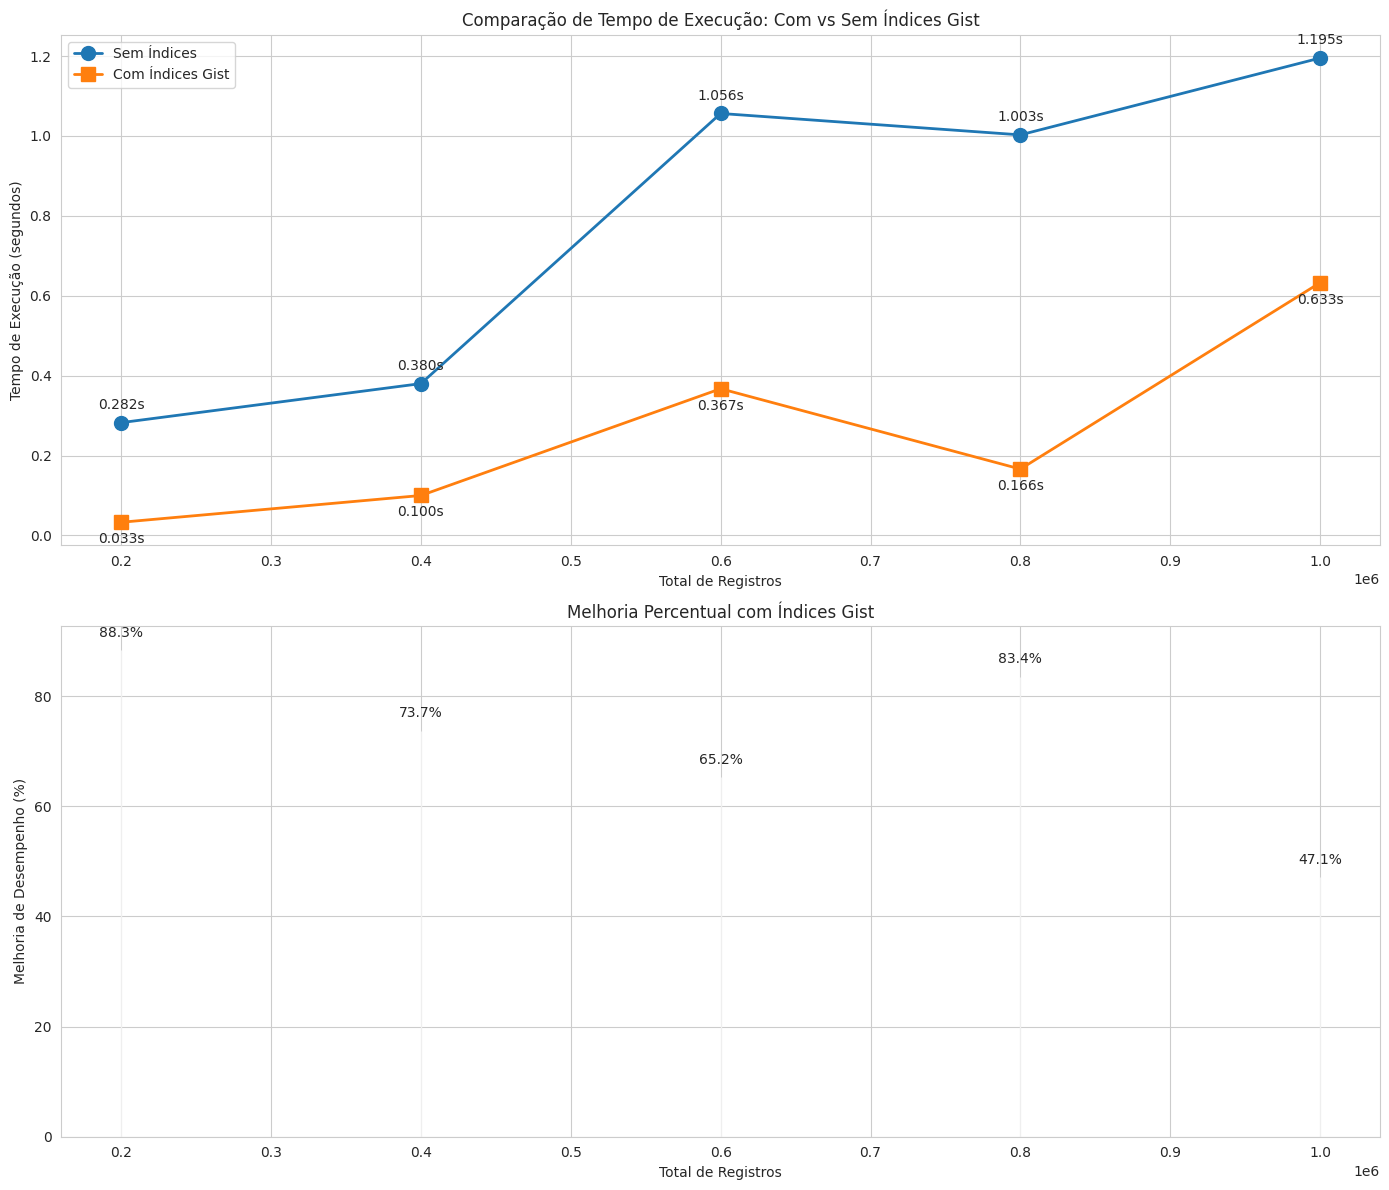

In [30]:
# Criar DataFrame com os resultados
df_resultados = pd.DataFrame({
    'Total de Registros': resultados_experimento['total_registros'],
    'Tempo sem Índices (s)': resultados_experimento['tempo_sem_indices'],
    'Tempo com Índices Gist (s)': resultados_experimento['tempo_com_indices'],
    'Número de Resultados': resultados_experimento['num_resultados'],
})

# Calcular a melhoria percentual
df_resultados['Melhoria (%)'] = (1 - df_resultados['Tempo com Índices Gist (s)'] / df_resultados['Tempo sem Índices (s)']) * 100

# Exibir tabela de resultados
print("Resultados do Experimento:")
print(df_resultados)

# Plotar gráfico comparativo
plt.figure(figsize=(14, 8))

# Criar dois subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Gráfico de linhas comparativas
ax1.plot(df_resultados['Total de Registros'], df_resultados['Tempo sem Índices (s)'], 'o-', linewidth=2, markersize=10, label='Sem Índices')
ax1.plot(df_resultados['Total de Registros'], df_resultados['Tempo com Índices Gist (s)'], 's-', linewidth=2, markersize=10, label='Com Índices Gist')
ax1.set_xlabel('Total de Registros')
ax1.set_ylabel('Tempo de Execução (segundos)')
ax1.set_title('Comparação de Tempo de Execução: Com vs Sem Índices Gist')
ax1.legend()
ax1.grid(True)

# Adicionar rótulos para ambas as linhas
for i, row in df_resultados.iterrows():
    # Rótulo para linha sem índices
    ax1.annotate(f"{row['Tempo sem Índices (s)']:.3f}s",
                xy=(row['Total de Registros'], row['Tempo sem Índices (s)']),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    # Rótulo para linha com índices
    ax1.annotate(f"{row['Tempo com Índices Gist (s)']:.3f}s",
                xy=(row['Total de Registros'], row['Tempo com Índices Gist (s)']),
                textcoords="offset points",
                xytext=(0,-15),
                ha='center')

# Gráfico de barras para porcentagem de melhoria
ax2.bar(df_resultados['Total de Registros'], df_resultados['Melhoria (%)'], color='green', alpha=0.7)
ax2.set_xlabel('Total de Registros')
ax2.set_ylabel('Melhoria de Desempenho (%)')
ax2.set_title('Melhoria Percentual com Índices Gist')
ax2.grid(True, axis='y')

# Adicionar valores em cada barra
for i, row in df_resultados.iterrows():
    ax2.annotate(f"{row['Melhoria (%)']:.1f}%",
                xy=(row['Total de Registros'], row['Melhoria (%)']),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

plt.tight_layout()
plt.show()

## Análise e Conclusão

### Índices Gist no PostgreSQL

Os índices Gist são especialmente úteis para consultas de igualdade (operador =) em colunas com alta cardinalidade. Eles funcionam aplicando uma função gist nos dados, criando um mapa que permite acesso rápido aos registros.

**Principais características dos índices Gist:**
- Otimizados para operações de igualdade exata (operador =)
- Não funcionam para outros operadores de comparação (<, >, <=, >=)
- Não suportam consultas por faixa (BETWEEN)
- Exigem mais espaço em disco que B-tree para muitos valores distintos

### Análise dos Resultados

Com base nos resultados acima, podemos observar:

1. **Impacto do Volume de Dados**: À medida que o volume de dados aumenta, o tempo de execução sem índices tende a crescer mais rapidamente que com índices.

2. **Eficácia dos Índices Gist**: Os índices gist mostraram melhorias significativas para nossa consulta específica, que utiliza igualdade exata para `u.cpf = '532.710.165-59'`.

3. **Porcentagem de Melhoria**: A melhoria percentual demonstra a eficiência dos índices gist para operações de igualdade em grandes volumes de dados.

### Conclusão

Os índices Gist no PostgreSQL são particularmente úteis em consultas como a testada, que envolve junções e filtros por igualdade. A implementação desses índices pode trazer ganhos significativos de desempenho, especialmente com o crescimento do volume de dados.

Para bases de dados de biblioteca como a usada neste experimento, índices Gist são uma escolha adequada para as colunas de identificação de recursos (IDs) e valores de filtro frequentemente usados em condições de igualdade, como CPF dos usuários.

In [31]:
# Fechar conexões com o banco de dados ao finalizar
DatabaseConnection.close_all_connections()
print("Conexões com o banco de dados fechadas.")

Conexões com o banco de dados fechadas.
